# Phishing Detection

## Required Packages

In [1]:
#!pip install python-whois
#!pip install googlesearch-python
#!pip install dnspython

In [101]:
import requests
import whois
from datetime import datetime
from googlesearch import search
import dns.resolver 

# Filter the uneccesary warnings
import warnings
warnings.filterwarnings("ignore")
 
import csv
import re

# Import pandas and numpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter

In [3]:
whiteList = open("white-list.txt", "r")
blackList = open("black-list.txt", "r")

## White-List

In [4]:
whiteList = whiteList.readlines()
def checkWhiteList(url, whiteList = whiteList):
    if url in whiteList:
        return True
    return False

## Black-List

In [5]:
blackList = blackList.readlines()

In [6]:
# source for appspot = https://www.sslcertificates.top/certificate/12296
domains = ["co.in", "co.uk", "co.za", "ac.in", "ac.th", "com.br", "ac.id", "com.ec", "org.au", "org.za", "com.hk", "org.ar", "com.au", ".io", "web.app", "appspot.com", "an.r.appspot.com", "app.google", "as.r.appspot.com", "de.r.appspot.com", "df.r.appspot.com", "dt.r.appspot.com", "du.r.appspot.com", "el.r.appspot.com", "et.r.appspot.com", "ew.r.appspot.com", "ey.r.appspot.com", "ez.r.appspot.com", "lz.r.appspot.com", "nn.r.appspot.com", "nw.r.appspot.com", "nz.r.appspot.com", "oa.r.appspot.com", "rj.r.appspot.com", "thinkwithgoogle.com", "ts.r.appspot.com", "tz.r.appspot.com", "uc.r.appspot.com", "ue.r.appspot.com", "uk.r.appspot.com", "uw.r.appspot.com", "withgoogle.com", "blogspot.com", "withyoutube.com", "wl.r.appspot.com", "wm.r.appspot.com", "wn.r.appspot.com", "app.google", "appspot.com", "thinkwithgoogle.com", "withgoogle.com", "withyoutube.com"]
BlackList = []
for url in blackList:
    index = 0
    # some has http or https or nothing
    if "http" in url:
        index = url.find('://')
        url = url[3:]
    url = url[index:]
    index = url.find('/')
    if index != -1:
        url = url[:index]
    prevUrl = url
    index = url.find('.')
    while index != -1:
        prevUrl = url
        url = url[index + 1:]
        if url in domains:
            break
        index = url.find('.')
    BlackList.append(prevUrl)
blackList = BlackList
BlackList = []
def checkBlackList(url, blackList = blackList):
    if url in blackList:
        return True
    return False

## Whois Tool

In [12]:
def check_whois(url):
    try:  
        w = whois.whois(url)
    except:
        return True
    try:
        d = w.expiration_date.year - w.creation_date.year
    except:
        try:
            d = w.expiration_date[0].year - w.creation_date[0].year
            w.expiration_date = w.expiration_date[0]
            w.creation_date = w.creation_date[0]
        except:
            d = 0
    # no expiration date or no creation date
    if not w.expiration_date or not w.creation_date:
        return True
    # difference <= 1 year or difference more than 200 years
    if d <= 1 or d > 200:
        return True
    # current date exceeds expiration date
    if datetime.now() > w.expiration_date:
        return True
    try:
        org = w.org
        reg = w.registrar
        email = w.emails
        status = w.status
        if org is None or reg is None or email is None or status is None:
            return True
    except:
        return True
    return False

In [13]:
# Checking non-phishing site
url = "https://www.google.com/"
check_whois(url)

Error trying to connect to socket: closing socket


True

In [9]:
# Checking phishing site
urls = ["https://cbsujavrh.ts.r.appspot.com/login.microsoftonline.com/common/oauth2", "https://www.netflix.verfiy-your-information.com/", "https://g-amazon.top/amazon/login/login.php"]
for url in urls:
  print(check_whois(url))

True
True
True


## Google Search

In [14]:
def check_google(url):
    index = -1
    rslt = search(url, num_results=0)
    if len(rslt) != 0:
        index = rslt[0].find('://')
        if index != -1:
            rslt = rslt[0][index + 3:]
        index = rslt.find('/')
        if index != -1:
            rslt = rslt[:index]
        index = url.find('://')
        if index != -1:
            url = url[index + 3:]  
        index = url.find('/')
        if index != -1:
            url = url[:index]
    if rslt == url:
        return False
    return True

In [15]:
# Checking non-phishing site
url = "www.google.com"
check_google(url)

False

In [16]:
# Checking phishing site
urls = ["https://cbsujavrh.ts.r.appspot.com/login.microsoftonline.com/common/oauth2", "http://continouscrusader.com/www.amazon.com/preferredmethods/payment/Amazon", "http://tiny.cc/m5md0y?platform=hootsuite", "https://g-amazon.top/amazon/login/login.php"]
for url in urls:
    print(check_google(url))

True
True
True
False


## ML Model

### ML Model 1

In [52]:
# Filter the uneccesary warnings
import warnings
warnings.filterwarnings("ignore")
 
# Import pandas and numpy
import pandas as pd
import numpy as np
import csv

In [53]:
data = pd.read_csv('dataset.csv')
data.head()

,index,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,1,-1,1,1,1,-1,-1,-1,-1,-1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,2,1,1,1,1,1,-1,0,1,-1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,3,1,0,1,1,1,-1,-1,-1,-1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,4,1,0,1,1,1,-1,-1,-1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,5,1,0,-1,1,1,-1,1,1,-1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [54]:
data = data.drop(['index'], axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   having_IP_Address            11055 non-null  int64
 1   URL_Length                   11055 non-null  int64
 2   Shortining_Service           11055 non-null  int64
 3   having_At_Symbol             11055 non-null  int64
 4   double_slash_redirecting     11055 non-null  int64
 5   Prefix_Suffix                11055 non-null  int64
 6   having_Sub_Domain            11055 non-null  int64
 7   SSLfinal_State               11055 non-null  int64
 8   Domain_registeration_length  11055 non-null  int64
 9   Favicon                      11055 non-null  int64
 10  port                         11055 non-null  int64
 11  HTTPS_token                  11055 non-null  int64
 12  Request_URL                  11055 non-null  int64
 13  URL_of_Anchor                11055 non-null  i

In [55]:
print(data.shape)
print(data.columns)

(11055, 31)
Index(['having_IP_Address', 'URL_Length', 'Shortining_Service',
       'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix',
       'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length',
       'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor',
       'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL',
       'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe',
       'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank',
       'Google_Index', 'Links_pointing_to_page', 'Statistical_report',
       'Result'],
      dtype='object')


In [56]:
classes = Counter(data['Result'].values)
print(classes.most_common())
class_dist = pd.DataFrame(classes.most_common(), columns=['Class', 'Num_Observations'])
class_dist

[(1, 6157), (-1, 4898)]


,Class,Num_Observations
0,1,6157
1,-1,4898


In [57]:
data.rename(columns={'Result': 'Class'}, inplace=True)
data['Class'] = data['Class'].map({-1:0, 1:1})
# 0: Phishing 1: Legitimate

In [58]:
data.describe()

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Class
count,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,...,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000
mean,0.313795,-0.633198,0.738761,0.700588,0.741474,-0.734962,0.063953,0.250927,-0.336771,0.628584,...,0.613388,0.816915,0.061239,0.377114,0.287291,-0.483673,0.721574,0.344007,0.719584,0.556943
std,0.949534,0.766095,0.673998,0.713598,0.671011,0.678139,0.817518,0.911892,0.941629,0.777777,...,0.789818,0.576784,0.998168,0.926209,0.827733,0.875289,0.692369,0.569944,0.694437,0.496769
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,...,1.000000,1.000000,-1.000000,-1.000000,0.000000,-1.000000,1.000000,0.000000,1.000000,0.000000
50%,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,1.000000,-1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,0.000000,1.000000,1.000000
75%,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [59]:
data.isna().sum()

having_IP_Address              0
URL_Length                     0
Shortining_Service             0
having_At_Symbol               0
double_slash_redirecting       0
Prefix_Suffix                  0
having_Sub_Domain              0
SSLfinal_State                 0
Domain_registeration_length    0
Favicon                        0
port                           0
HTTPS_token                    0
Request_URL                    0
URL_of_Anchor                  0
Links_in_tags                  0
SFH                            0
Submitting_to_email            0
Abnormal_URL                   0
Redirect                       0
on_mouseover                   0
RightClick                     0
popUpWidnow                    0
Iframe                         0
age_of_domain                  0
DNSRecord                      0
web_traffic                    0
Page_Rank                      0
Google_Index                   0
Links_pointing_to_page         0
Statistical_report             0
Class     

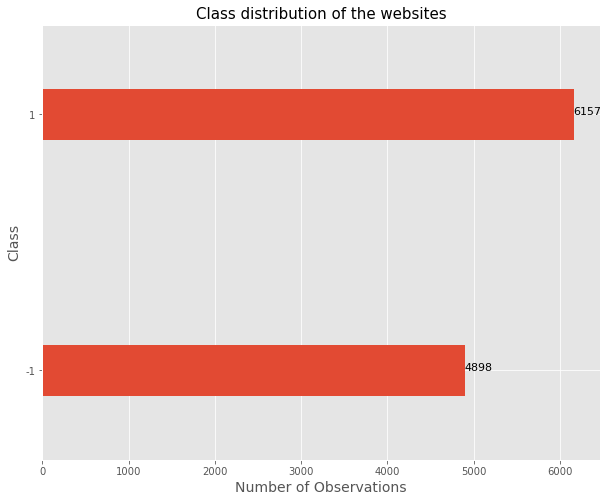

In [60]:
# display distribution
plt.style.use('ggplot')

subplot = class_dist.groupby('Class')['Num_Observations'].sum().plot(kind='barh', width=0.2, figsize=(10,8))

subplot.set_title('Class distribution of the websites', fontsize = 15)
subplot.set_xlabel('Number of Observations', fontsize = 14)
subplot.set_ylabel('Class', fontsize = 14)

for i in subplot.patches:
    subplot.text(i.get_width()+0.1, i.get_y()+0.1, \
            str(i.get_width()), fontsize=11)

In [63]:
# Data Splitting
X = data.iloc[:,0:30].values.astype(int)
y = data.iloc[:,30].values.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=np.random.seed(7))

In [64]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [67]:

from sklearn.metrics import accuracy_score, classification_report

print('Accuracy score of the Logistic Regression classifier with default hyperparameter values {0:.2f}%'.format(accuracy_score(y_test, logreg.predict(X_test))*100.))
print('\n')
print('----Classification report of the Logistic Regression classifier with default hyperparameter value----')
print('\n')
print(classification_report(y_test, logreg.predict(X_test), target_names=['Phishing Websites', 'Normal Websites']))

Accuracy score of the Logistic Regression classifier with default hyperparameter values 93.71%


----Classification report of the Logistic Regression classifier with default hyperparameter value----


                   precision    recall  f1-score   support

Phishing Websites       0.94      0.92      0.93       974
  Normal Websites       0.94      0.95      0.94      1237

         accuracy                           0.94      2211
        macro avg       0.94      0.94      0.94      2211
     weighted avg       0.94      0.94      0.94      2211



In [68]:
preds = logreg.predict(X_test).astype(int)
accuracy = logreg.score(X_test,y_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
AUC = metrics.auc(fpr,tpr)
F1 = metrics.f1_score(y_test,preds)
print(accuracy)
print(AUC)
print(F1)
print(X_test)

0.9371325192220714
0.935302505399066
0.944199116820554
[[ 1 -1  1 ...  1  0  1]
 [-1 -1  1 ...  1  1  1]
 [ 1 -1  1 ... -1  0  1]
 ...
 [ 1 -1  1 ...  1  1  1]
 [ 1 -1  1 ...  1  1  1]
 [-1 -1  1 ... -1  1  1]]


### ML Model 2

In [70]:
data = pd.read_csv('dataset.csv')
data.head()

,index,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,1,-1,1,1,1,-1,-1,-1,-1,-1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,2,1,1,1,1,1,-1,0,1,-1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,3,1,0,1,1,1,-1,-1,-1,-1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,4,1,0,1,1,1,-1,-1,-1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,5,1,0,-1,1,1,-1,1,1,-1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [71]:
data = data.drop(columns=['index', 'having_Sub_Domain', 'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor',
       'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL',
       'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe', 'Page_Rank', 'Links_pointing_to_page', 'Statistical_report'])
data.columns

Index(['having_IP_Address', 'URL_Length', 'Shortining_Service',
       'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix',
       'SSLfinal_State', 'Domain_registeration_length', 'age_of_domain',
       'DNSRecord', 'web_traffic', 'Google_Index', 'Result'],
      dtype='object')

In [74]:
data.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
having_IP_Address,-1,1,1,1,1,-1,1,1,1,1,1,1,-1,1,1,1,1,1,1,1
URL_Length,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,-1,-1,-1,1,1
Shortining_Service,1,1,1,1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,1
having_At_Symbol,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,-1,1,1,1,1
double_slash_redirecting,-1,1,1,1,1,-1,1,1,1,1,1,1,-1,1,1,1,1,1,1,1
Prefix_Suffix,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1
SSLfinal_State,-1,1,-1,-1,1,1,-1,-1,1,1,1,-1,0,-1,1,0,1,0,1,1
Domain_registeration_length,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,1,1,-1,1,-1,1,1,-1
age_of_domain,-1,-1,1,-1,-1,1,1,-1,1,1,-1,-1,1,-1,1,1,1,-1,1,1
DNSRecord,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1


In [77]:
X = data.iloc[:,0:-1].values.astype(int)
y = data.iloc[:,-1].values.astype(int)
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=np.random.seed(7))

#### Logistic Regression

In [78]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [79]:

from sklearn.metrics import accuracy_score, classification_report

print('Accuracy score of the Logistic Regression classifier with default hyperparameter values {0:.2f}%'.format(accuracy_score(y_test, logreg.predict(X_test))*100.))
print('\n')
print('----Classification report of the Logistic Regression classifier with default hyperparameter value----')
print('\n')
print(classification_report(y_test, logreg.predict(X_test), target_names=['Phishing Websites', 'Normal Websites']))

Accuracy score of the Logistic Regression classifier with default hyperparameter values 89.33%


----Classification report of the Logistic Regression classifier with default hyperparameter value----


                   precision    recall  f1-score   support

Phishing Websites       0.90      0.85      0.88       974
  Normal Websites       0.89      0.93      0.91      1237

         accuracy                           0.89      2211
        macro avg       0.89      0.89      0.89      2211
     weighted avg       0.89      0.89      0.89      2211



In [80]:
preds = logreg.predict(X_test).astype(int)
accuracy = logreg.score(X_test,y_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
AUC = metrics.auc(fpr,tpr)
F1 = metrics.f1_score(y_test,preds)
print(accuracy)
print(AUC)
print(F1)

0.8932609678878336
0.8887821433254928
0.9066455696202532


#### Decision Tree Classifier

In [81]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [85]:

from sklearn.metrics import accuracy_score, classification_report

print('Accuracy score of the Decision Tree classifier classifier with default hyperparameter values {0:.2f}%'.format(accuracy_score(y_test, dtc.predict(X_test))*100.))
print('\n')
print('----Classification report of the Decision Tree classifier with default hyperparameter value----')
print('\n')
print(classification_report(y_test, dtc.predict(X_test), target_names=['Phishing Websites', 'Normal Websites']))

Accuracy score of the Decision Tree classifier classifier with default hyperparameter values 92.58%


----Classification report of the Decision Tree classifier with default hyperparameter value----


                   precision    recall  f1-score   support

Phishing Websites       0.92      0.91      0.92       974
  Normal Websites       0.93      0.94      0.93      1237

         accuracy                           0.93      2211
        macro avg       0.93      0.92      0.92      2211
     weighted avg       0.93      0.93      0.93      2211



In [83]:
preds = dtc.predict(X_test).astype(int)
accuracy = dtc.score(X_test,y_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
AUC = metrics.auc(fpr,tpr)
F1 = metrics.f1_score(y_test,preds)
print(accuracy)
print(AUC)
print(F1)

0.9258254183627318
0.9241059793930803
0.9340305711987127


#### Bagging

In [84]:
bg = BaggingClassifier(base_estimator = DecisionTreeClassifier(), max_samples=0.5, n_estimators=50)
bg.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=0.5,
                  n_estimators=50)

In [86]:
from sklearn.metrics import accuracy_score, classification_report

print('Accuracy score of the Bagging classifier with default hyperparameter values {0:.2f}%'.format(accuracy_score(y_test, bg.predict(X_test))*100.))
print('\n')
print('----Classification report of the Bagging classifier with default hyperparameter value----')
print('\n')
print(classification_report(y_test, bg.predict(X_test), target_names=['Phishing Websites', 'Normal Websites']))

Accuracy score of the Bagging classifier with default hyperparameter values 92.85%


----Classification report of the Bagging classifier with default hyperparameter value----


                   precision    recall  f1-score   support

Phishing Websites       0.93      0.91      0.92       974
  Normal Websites       0.93      0.94      0.94      1237

         accuracy                           0.93      2211
        macro avg       0.93      0.93      0.93      2211
     weighted avg       0.93      0.93      0.93      2211



In [87]:
preds = bg.predict(X_test).astype(int)
accuracy = bg.score(X_test,y_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
AUC = metrics.auc(fpr,tpr)
F1 = metrics.f1_score(y_test,preds)
print(accuracy)
print(AUC)
print(F1)

0.9285391225689733
0.9267494883129517
0.9364951768488746


#### Ada Boosting

In [89]:
adb = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(), n_estimators=50, learning_rate=0.3)
adb.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), learning_rate=0.3)

In [91]:
from sklearn.metrics import accuracy_score, classification_report

print('Accuracy score of the Ada Boosting classifier with default hyperparameter values {0:.2f}%'.format(accuracy_score(y_test, adb.predict(X_test))*100.))
print('\n')
print('----Classification report of the Ada Boosting classifier with default hyperparameter value----')
print('\n')
print(classification_report(y_test, adb.predict(X_test), target_names=['Phishing Websites', 'Normal Websites']))

Accuracy score of the Ada Boosting classifier with default hyperparameter values 92.49%


----Classification report of the Ada Boosting classifier with default hyperparameter value----


                   precision    recall  f1-score   support

Phishing Websites       0.92      0.91      0.91       974
  Normal Websites       0.93      0.94      0.93      1237

         accuracy                           0.92      2211
        macro avg       0.92      0.92      0.92      2211
     weighted avg       0.92      0.92      0.92      2211



In [90]:
preds = adb.predict(X_test).astype(int)
accuracy = adb.score(X_test,y_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
AUC = metrics.auc(fpr,tpr)
F1 = metrics.f1_score(y_test,preds)
print(accuracy)
print(AUC)
print(F1)

0.9249208502939846
0.9230792853479057
0.9332797427652733


### Hybrid Model

In [102]:
def check_dns(url):
    try:
        w = whois.whois(url)
        domain = w.domain_name[0]
    except:
        return True
    try:
        result = dns.resolver.query(domain, 'A')
        return False
    except:
        return True

In [98]:
def process_url(url):
    having_IP_Address = -1 
    URL_Length = -1 
    Shortining_Service = -1 
    having_At_Symbol = -1 
    SSLfinal_State = -1
    double_slash_redirecting = -1 
    Prefix_Suffix = -1 
    age_of_domain = -1
    DNSRecord = -1
    web_traffic = -1 
    Google_Index = -1
    Domain_registeration_length = -1

    # having_IP_Address
    index = url.find('://')
    if index != -1:
        temp = url[index + 3:]
    a = re.search("(2[0-4][0-9]|2[5][0-5]|[1]*[0-9]*[0-9])\.(2[0-4][0-9]|2[5][0-5]|[1]*[0-9]*[0-9])\.(2[0-4][0-9]|2[5][0-5]|[1]*[0-9]*[0-9])\.(2[0-4][0-9]|2[5][0-5]|[1]*[0-9]*[0-9])", temp)
    if a:
        having_IP_Address = 1

    # URL_length
    length = len(url)
    if length >= 75 and length <= 100:
        URL_Length = 0
    elif length > 100:
        URL_Length = 1
 
    # Shortining_Service
    index = url.find('://')
    if index != -1:
        url = url[index + 3:]
    if ("bit.ly" in url or "tinyurl" in url) and (len(url) <= 30):
        Shortining_Service = 1

    # having_At_Symbol
    check = url.find('@')
    if check != -1:
        having_At_Symbol = 1
    
    
    # SSLfinal_State
    # not finding https directly because it may be in the right part of url
    http = url.find("://")
    if http != -1:
        if url[http - 1] != "s":
            SSLfinal_State = 1

    # double_slash_redirecting
    check = url.find('//')
    if check != -1:
        double_slash_redirecting = 1
            
    # Domain_registeration_length
    # age_of_domain
    try:  
        w = whois.whois(url)
    except:
        Domain_registeration_length = 1
        age_of_domain = 1   
    try:
        d = w.expiration_date.year - w.creation_date.year
    except:
        try:
            d = w.expiration_date[0].year - w.creation_date[0].year
            w.expiration_date = w.expiration_date[0]
            w.creation_date = w.creation_date[0]
        except:
            d = 0
            Domain_registeration_length = 1
            age_of_domain = 1
    if d == 1:
        Domain_registeration_length = 1
    if w.creation_date.month - datetime.now().month <= 6:
        age_of_domain = 1 

    # DNSRecord
    rslt = check_dns(url)
    if rslt == True:
        DNSRecord = 1

    # web_traffic
    index = url.find('://')
    url1 = url[index + 3:]
    index = url1.find('/')
    domain = url1[:index]
    try:
        w = whois.whois(url)
        domain = w.domain_name[0]
        rslt = checkWhiteList(domain)
        if rslt == False:
            web_traffic = 1
    except:
        pass
    
    # Prefix_Suffix
    check = domain.find('-')
    if check != -1:
        Prefix_Suffix = 1
        
    #Google_index
    rslt = check_google(url)
    if rslt == True:
        Google_Index = 1
 
    result = [having_IP_Address, URL_Length, Shortining_Service,
       having_At_Symbol, double_slash_redirecting, Prefix_Suffix,
       SSLfinal_State, Domain_registeration_length, age_of_domain,
       DNSRecord, web_traffic, Google_Index]
    return result 


In [94]:
data.columns

Index(['having_IP_Address', 'URL_Length', 'Shortining_Service',
       'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix',
       'SSLfinal_State', 'Domain_registeration_length', 'age_of_domain',
       'DNSRecord', 'web_traffic', 'Google_Index', 'Result'],
      dtype='object')

In [95]:
def detect_phishing(url):
    domain = url
    # Get domain name using whois command
    try:
        w = whois.whois(url)
        domain = w.domain_name
    except:
        pass
 
    # White-list approach
    rslt = checkWhiteList(domain)
    if rslt == True:
        return 'Non-phishing'
 
    # Black-list approach
    rslt = checkBlackList(domain)
    if rslt == True:
        return 'Phishing'
 
    # Whois Tool
    whois_rslt = False
    whois_rslt = check_whois(url)
 
    # Google Search
    google_rslt = False
    google_rslt = check_google(url)
 
 
    if whois_rslt == True and google_rslt == True:
        return 'Phishing'
 
    # ML approach
    url_features = process_url(url)
    ml_rslt = bg.predict([url_features]).astype(int)
    if ml_rslt[0] == 1 and (whois_rslt == True or google_rslt == True):
        return 'Phishing'
    else:
        return 'Non-phishing'
 
    return 'Non-phishing'

In [96]:
# Checking phishing site
urls = ["https://cbsujavrh.ts.r.appspot.com/login.microsoftonline.com/common/oauth2", "https://www.netflix.verfiy-your-information.com/", "http://12.34.56.78/firstgenericbank/account-update/", "http://promocao.pl/hot18664c6/67f37/741a1/847/dc01/", "http://www."]
for url in urls:
    print(detect_phishing(url))

Phishing
Phishing
Phishing
Phishing
Phishing


In [103]:
# Checking non-phishing site
urls = ['https://www.geeksforgeeks.org/php-file_exists-function/', 'https://devmesh.intel.com/projects/detecting-phishing-websites-using-neural-networks', 'https://github.com/sayakpaul/Phishing-Websites-Detection', 'https://stackoverflow.com/questions/13148429/how-to-change-the-order-of-dataframe-columns', 'https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html', 'https://stackoverflow.com/questions/44268763/can-not-import-module-search-from-google-module-in-python', 'https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92', 'https://stackoverflow.com/questions/23086383/how-to-test-nonetype-in-python', 'https://pypi.org/project/googlesearch-python/', 'https://www.shabdkosh.com/dictionary/english-marathi/lyric/lyric-meaning-in-marathi', 'https://helloenglish.com/translate/english-marathi-dictionary/meaning-of-lyrics-in-Marathi', 'https://translate.google.com/translate_t?hl=en&sl=en&tl=nl']
for url in urls:
    print(detect_phishing(url))

Non-phishing
Non-phishing
Non-phishing
Non-phishing
Non-phishing
Non-phishing
Non-phishing
Non-phishing
Non-phishing
Non-phishing
Non-phishing
Non-phishing


In [104]:
# google-search
# url1 is non-phishing site
# url2 is phishing site
url1 = 'https://portal2.passportindia.gov.in/AppOnlineProject/welcomeLink'
url2 = 'http://www.indiapassport.org'
print(check_google(url1))
print(check_google(url2))

True
False


In [105]:
# whois tool
# url1 is non-phishing site
# url2 is phishing site
url1 = 'https://portal2.passportindia.gov.in/AppOnlineProject/welcomeLink'
url2 = 'http://www.indiapassport.org'
print(check_whois(url1))
print(check_whois(url2))

True
True


In [106]:
# Hybrid model
# url1 is non-phishing site
# url2 is phishing site
url1 = 'https://portal2.passportindia.gov.in/AppOnlineProject/welcomeLink'
url2 = 'http://www.indiapassport.org'
print(detect_phishing(url1))
print(detect_phishing(url2))

Phishing
Non-phishing
